In [1]:
import numpy as np
import matplotlib.pyplot as plt

from deepthink.optimizers import Adam
from deepthink.layers import Dense, Conv2D, MaxPooling, Flatten
from deepthink.model import Model
from deepthink.activations import ReLU,  Softmax
from deepthink.utils import load_mnist_data, display_confusion_matrix
from deepthink.loss import CategoricalCrossEntropy
from deepthink.metrics import confusion_matrix


# Set default matplotlib style
plt.style.use('ggplot')

## MNIST classification example

The purpose of this notebook is to demonstrate how to train a convolutional neural network (CNN) on the MNIST dataset. This is a very commonly used dataset of handwritten digits where the goal is to predict the associated label from 10 classes (the digits 0-9). More information can be found [here](http://yann.lecun.com/exdb/mnist/).

The model architecture is based on LeNet, a CNN structure proposed by LeCun et al. in 1998 in [this](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) paper. We have simplified the structure somewhat and reduced the number of traininable parameters. Our purpose is to demonstrate functionality, not set state-of-the-art results.

The original architecture is illustrated in the image below from the original LeNet paper. Note, the input shows image dimensions of 32x32, this is an error in the paper the input was actually 28x28. Our model replicates the convolutional layers but we only use one fully-connected layer with 16 neurons whereas the original used two layer with 120 and 84 neurons. 

![LeNet model](../Data/LeNet.jpg)

### Loading the data

The load_mnist_data function below loads the MNIST dataset, it returns 60k training and 10k test images and labels. The function normalizes the data to be between 0-1 by dividing by the maximum value, 255. The labels are also one-hot-encoded to allow the model to make predictions for each class.

In [2]:
# Helper functions
def show_images(images, labels, figsize=(8, 8)):
    """
    A function used to display four images.
    Used for visualizing the MNIST dataset.

    Parameters
    ----------
    images : np.array
        A Numpy array of the images to visualize, in
        channel first format i.e.
        (batch, channels, height, width)
    labels : list
        A list of the labels to display. This should
        be a list of strings.
    figsize : tuple,default=(8, 8)
        The Matplotlib figure-size to use.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i][0], cmap='gray')
        ax.title.set_text(labels[i])
        ax.grid(False)
    plt.show()

In [3]:
# Load dataset
training_data, test_data = load_mnist_data('../Data/mnist784.p')

X_train, y_train = training_data
X_test, y_test = test_data

# Show data dimensions
print('Training data & labels: ', X_train.shape, y_train.shape)
print('Testing data & labels: ', X_test.shape, y_test.shape)

Training data & labels:  (60000, 1, 28, 28) (60000, 10)
Testing data & labels:  (10000, 1, 28, 28) (10000, 10)


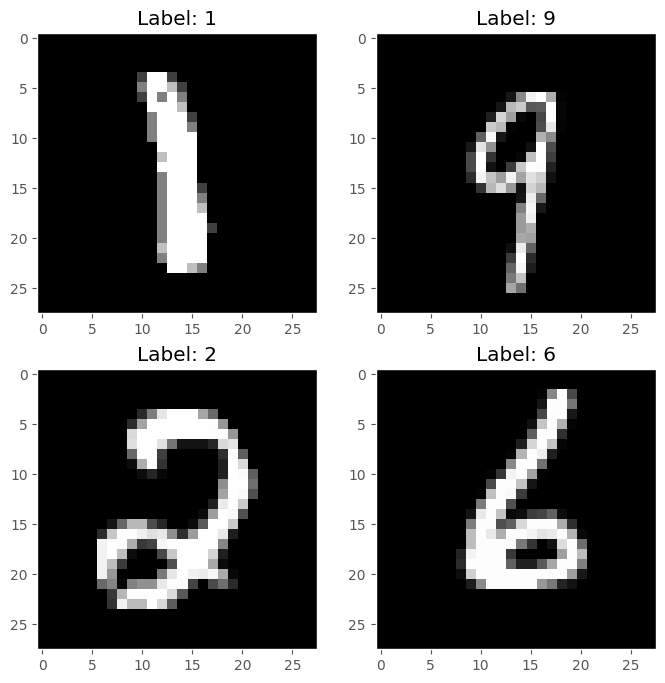

In [4]:
# Display some random images and their labels
indices = np.random.randint(X_train.shape[0], size=4)
samples = X_train[indices]
labels = np.argmax(y_train[indices], axis=1)
label_strs = [f'Label: {i}' for i in labels]

show_images(samples, label_strs)

In [5]:
# Define hyperparameters
input_dims = X_train.shape[1]
num_classes = y_train.shape[1]
learning_rate = 0.0025
batch_size = 128
init_type = 'he_uniform'

In [6]:
# Creating the model
opt = Adam(learning_rate)
model = Model(opt, cost=CategoricalCrossEntropy(),
              metrics=['Accuracy'],
              batch_size=batch_size)

model.add_layer(Conv2D(kernel_size=5, n_filters=6,
                       padding=2, stride=1,
                       weight_init=init_type,
                       input_shape=(batch_size, 1, 28, 28)))
model.add_layer(ReLU())
model.add_layer(MaxPooling())
model.add_layer(Conv2D(kernel_size=5, n_filters=16,
                       padding=0, stride=1,
                       weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(MaxPooling())
model.add_layer(Flatten())
model.add_layer(Dense(16, weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(10, weight_init=init_type))
model.add_layer(Softmax())

model.initialize()

In [7]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Conv2D                    (None, 6, 28, 28)                   150
ReLU Activation           (None, 6, 28, 28)                     0
MaxPooling                (None, 6, 14, 14)                     0
Conv2D                    (None, 16, 10, 10)                 2400
ReLU Activation           (None, 16, 10, 10)                    0
MaxPooling                (None, 16, 5, 5)                      0
Flatten                   (None, 400)                           0
Dense Layer               (None, 16)                         6400
ReLU Activation           (None, 16)                            0
Dense Layer               (None, 10)                          160
Softmax Activation        (None, 10)                            0
Total params: 9,158


In [8]:
# Training the model
history = model.train((X_train, y_train),
                      validation_data=(X_test, y_test),
                      epochs=5)

100%|█████████████████████████████████████████| 468/468 [01:45<00:00,  4.43it/s]


Epoch: 1/5, elapsed-time: 129.64s - loss: 0.0991 - Accuracy: 0.9707 - val_loss: 0.0920 - val_Accuracy: 0.9703 - 


100%|█████████████████████████████████████████| 468/468 [01:45<00:00,  4.42it/s]


Epoch: 2/5, elapsed-time: 239.08s - loss: 0.0779 - Accuracy: 0.9765 - val_loss: 0.0586 - val_Accuracy: 0.9817 - 


100%|█████████████████████████████████████████| 468/468 [01:46<00:00,  4.38it/s]


Epoch: 3/5, elapsed-time: 349.54s - loss: 0.0564 - Accuracy: 0.9833 - val_loss: 0.0432 - val_Accuracy: 0.9867 - 


100%|█████████████████████████████████████████| 468/468 [01:46<00:00,  4.40it/s]


Epoch: 4/5, elapsed-time: 459.49s - loss: 0.0455 - Accuracy: 0.9860 - val_loss: 0.0379 - val_Accuracy: 0.9876 - 


100%|█████████████████████████████████████████| 468/468 [01:45<00:00,  4.43it/s]


Epoch: 5/5, elapsed-time: 568.78s - loss: 0.0385 - Accuracy: 0.9877 - val_loss: 0.0333 - val_Accuracy: 0.9886 - 


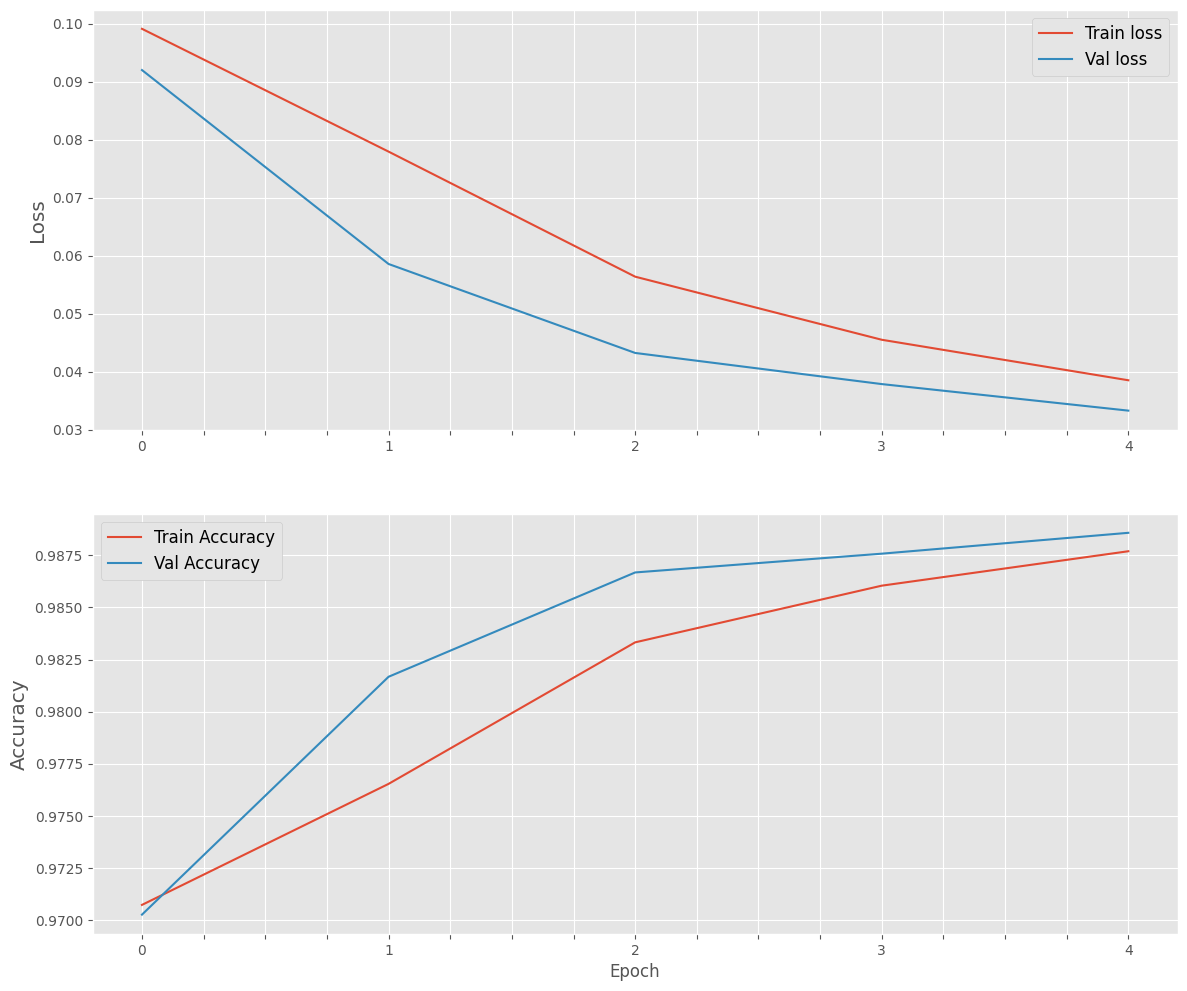

In [9]:
history.plot_history()

In [10]:
# Get predictions on test set
test_preds = model.get_predictions(X_test)

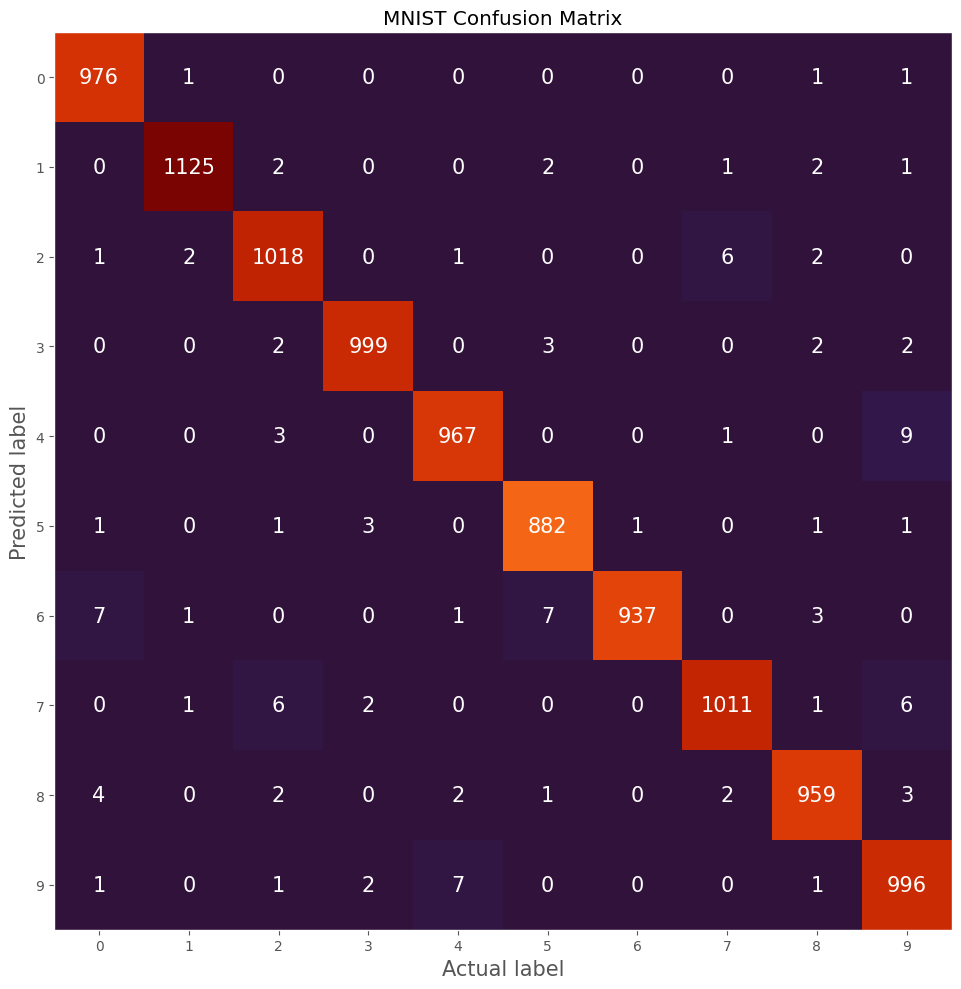

In [11]:
# Get confusion matrix and display it
cm = confusion_matrix(y_test, test_preds, 10)

display_confusion_matrix(cm, 10, title='MNIST Confusion Matrix')